In [26]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [27]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [29]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [30]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [31]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [32]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [33]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [34]:
# Find the most recent date in the data set.
last_date = session.query(func.max(measurement.date)).scalar()

print(last_date)

2017-08-23


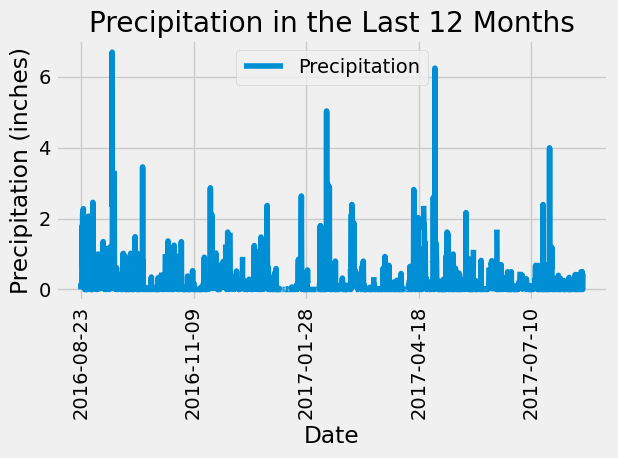

In [35]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in the dataset
one_year_ago = (pd.to_datetime(last_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation in the Last 12 Months')
plt.tight_layout()
plt.show()


In [36]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [37]:
# Design a query to calculate the total number of stations in the dataset
number_of_stations = session.query(station.name).count()
print(number_of_stations)

9


In [38]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [measurement.station,func.count(measurement.id)]
active_stations = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
most_active_station = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).first()
most_active_station

(54.0, 85.0, 71.66378066378067)

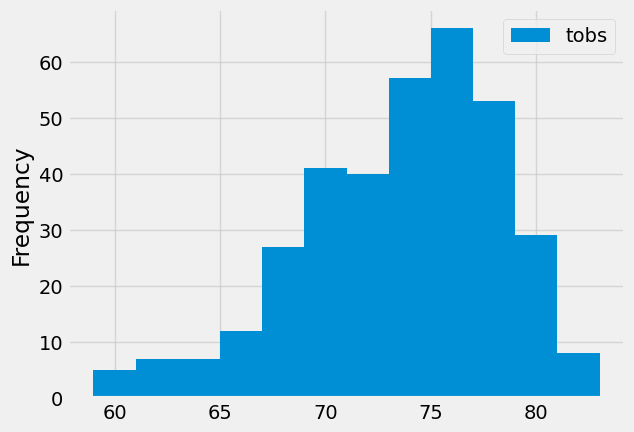

In [41]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_result = session.query(measurement.tobs).\
    filter(measurement.station == active_stations[0][0]).\
    filter(measurement.date >= one_year_ago).all()
temperatures = list(np.ravel(query_result))

sel = [station.station,station.name,station.latitude,station.longitude,station.elevation]
query_result = session.query(*sel).all()
stations_desc = pd.DataFrame(query_result, columns=['Station','Name','Latitude','Longitude','Elevation'])

station_name = stations_desc.loc[stations_desc["Station"] == active_stations[0][0],"Name"].tolist()[0]

plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.legend()



# Close Session

In [42]:
# Close Session
session.close()